# rasterio tour

In [22]:
import rasterio # v. 1.03
from rasterio.plot import show
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams["figure.figsize"] = (22,22)

## opening & retrieving information

In [2]:
# open dataset: a visible geotiff, for now
ds = rasterio.open("satellite_images/20170710_023840_0c75_3B_Visual.tif")
ds

<open DatasetReader name='satellite_images/20170710_023840_0c75_3B_Visual.tif' mode='r'>

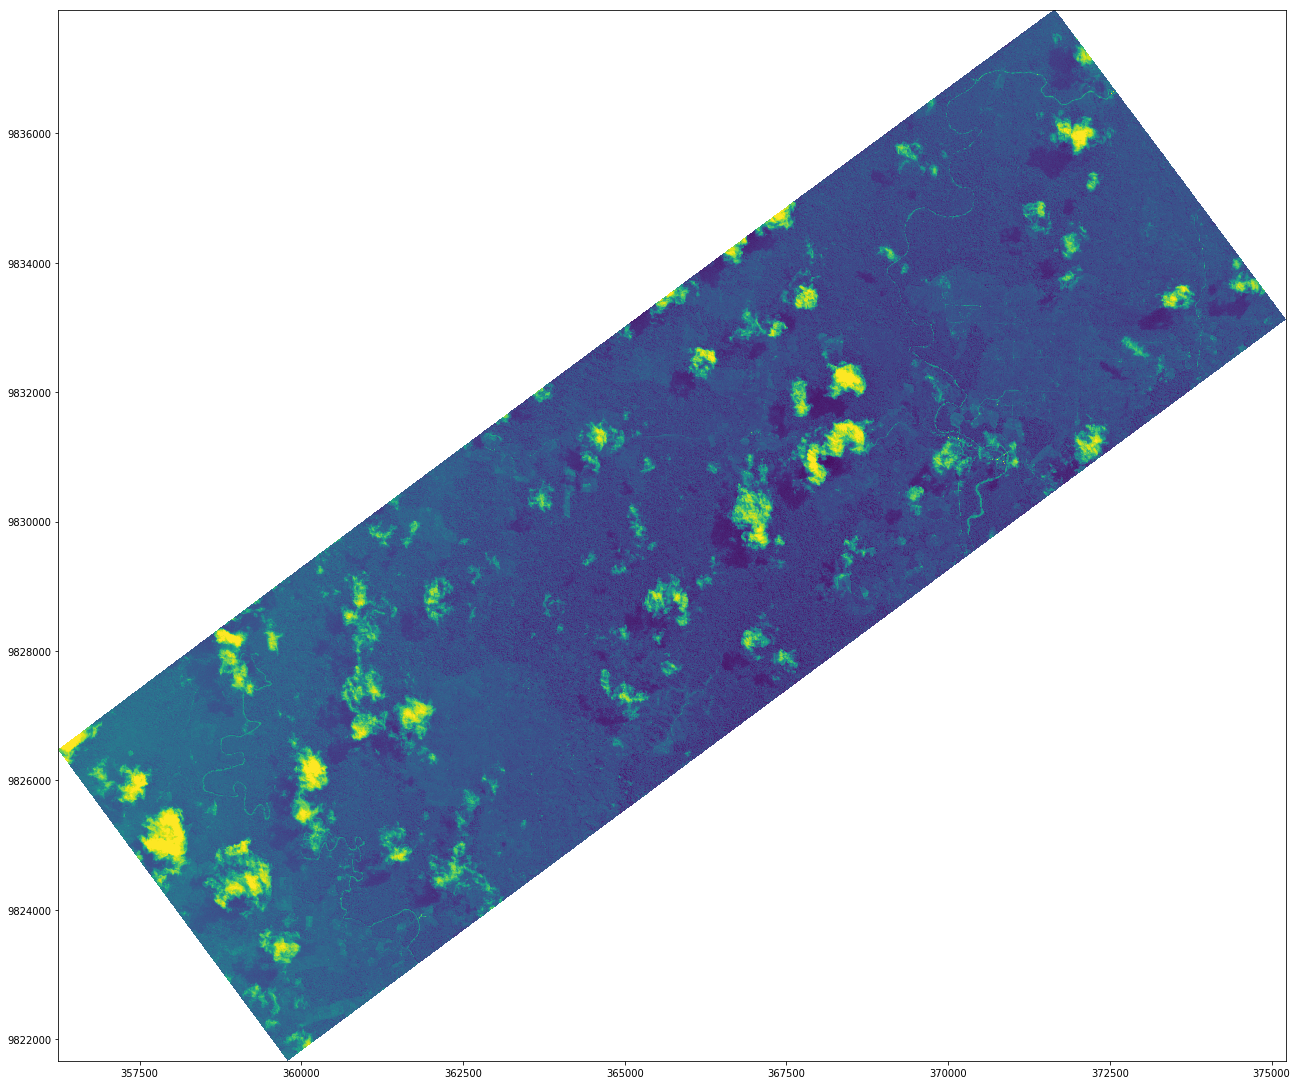

In [23]:
# before doing anything else, plot it using rasterio's show method
# so that the axis units are meters (reference point: see further below)
show(ds)

In [4]:
# bands and dimensions
ds.count, ds.width, ds.height

(4, 6326, 5416)

In [5]:
# number type in each band
{i: dtype for i, dtype in zip(ds.indexes, ds.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8', 4: 'uint8'}

In [6]:
# bounding box (in meters; reference point see below)
ds.bounds

BoundingBox(left=356244.0, bottom=9821664.0, right=375222.0, top=9837912.0)

In [7]:
# The transform attribute is an affine transformation matrix that maps 
# pixel locations in (row, col) coordinates to (x, y) spatial positions.
ds.transform

Affine(3.0, 0.0, 356244.0,
       0.0, -3.0, 9837912.0)

In [8]:
# The product of this matrix and (0, 0), the row and column coordinates of 
# the upper left corner of the dataset, is the spatial position of the upper left 
# corner (in m)...
ds.transform * (0, 0)

(356244.0, 9837912.0)

In [9]:
# ...relative to the dataset's  coordinate reference system
ds.crs

CRS({'init': 'epsg:32750'})

## reading data

In [10]:
# to read just one band (into numpy array):
d1 = ds.read(1)

In [11]:
# read all data into numpy array: interestingly, the bands are in the first dimension!
d = ds.read()
d.shape

(4, 5416, 6326)

## indexing: converting from pixels to geo coordinates and back

In [12]:
# geo coordinates -> row & column indexes
# row and column indexes of pixel at a given distance from upper left corner:
x, y = (ds.bounds.left + 1000, ds.bounds.top - 2000)
rIx, cIx = ds.index(x, y)
rIx, cIx

(666, 333)

In [13]:
# row & column indexes -> geo coordinates
ds.xy(rIx,cIx)

(357244.5, 9835912.5)

In [14]:
# so, let's compute the edge length of a 512 by 512 square (should be
# close to 1536 for Planetscope data)
edge_len_m = ds.xy(1,512)[0] - ds.xy(1,1)[0]
edge_len_m

1533.0

# Geopandas

In [15]:
import geopandas as gpd

In [16]:
rd = gpd.read_file('NewRoads_3093_a_20170710.geojson')
rd.head(5)

,name,geometry
0,boundingPoly_3093_a_20170710,POLYGON Z ((115.7399931442474 -1.5943727265987...
1,20170710_hh_2,LINESTRING Z (115.8055981691395 -1.67716606177...
2,20170710_hh_2,LINESTRING Z (115.7961624506558 -1.66525108794...
3,20170710_hh_2,LINESTRING Z (115.7950305862791 -1.61289952009...
4,20170710_hh_2,LINESTRING Z (115.757697970258 -1.593261181860...


In [17]:
# weed out rows with none
rd = rd.iloc[(rd.geometry.values != None),:]

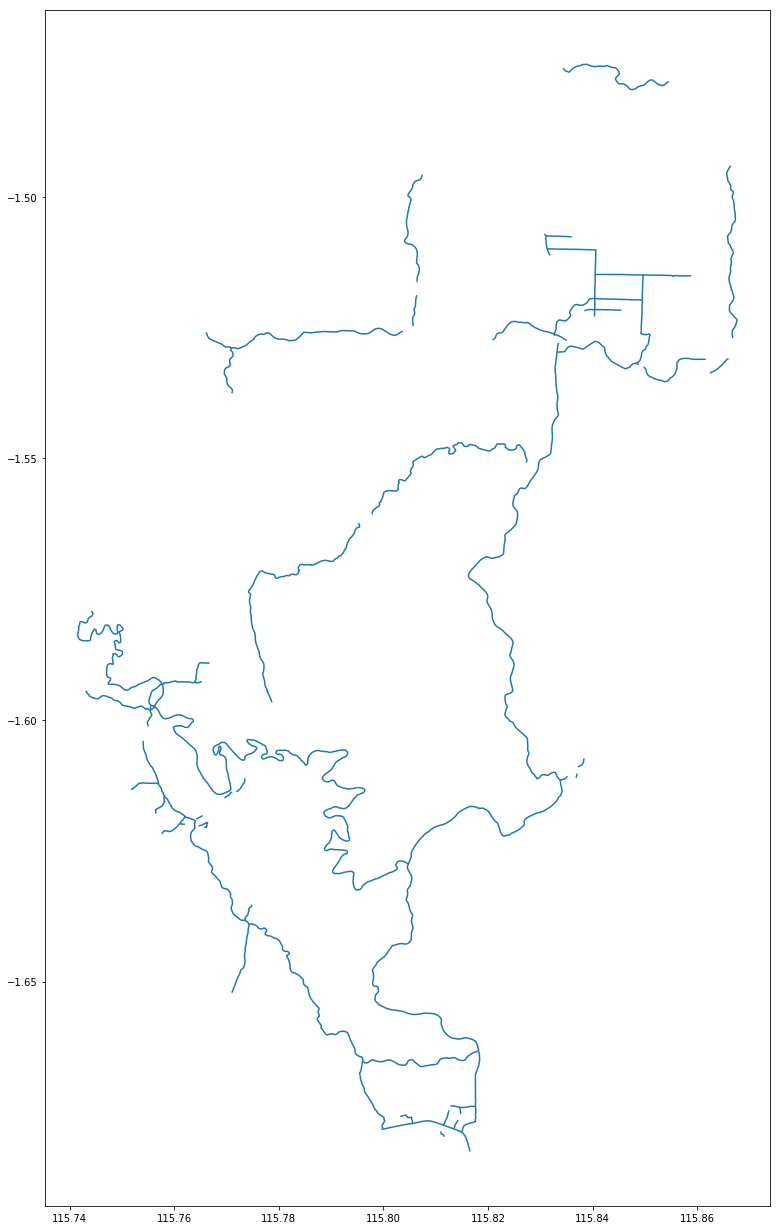

In [24]:
# plot lon/lat
rd.iloc[1::,:].plot()

In [19]:
# the roads' coordinate reference system
rd.crs

{'init': 'epsg:4326'}

In [20]:
# here's the key point: transform the roads' reference system into that of the geotiff
rd_transformed = rd
rd_transformed = rd.to_crs({'init': 'epsg:32750'})

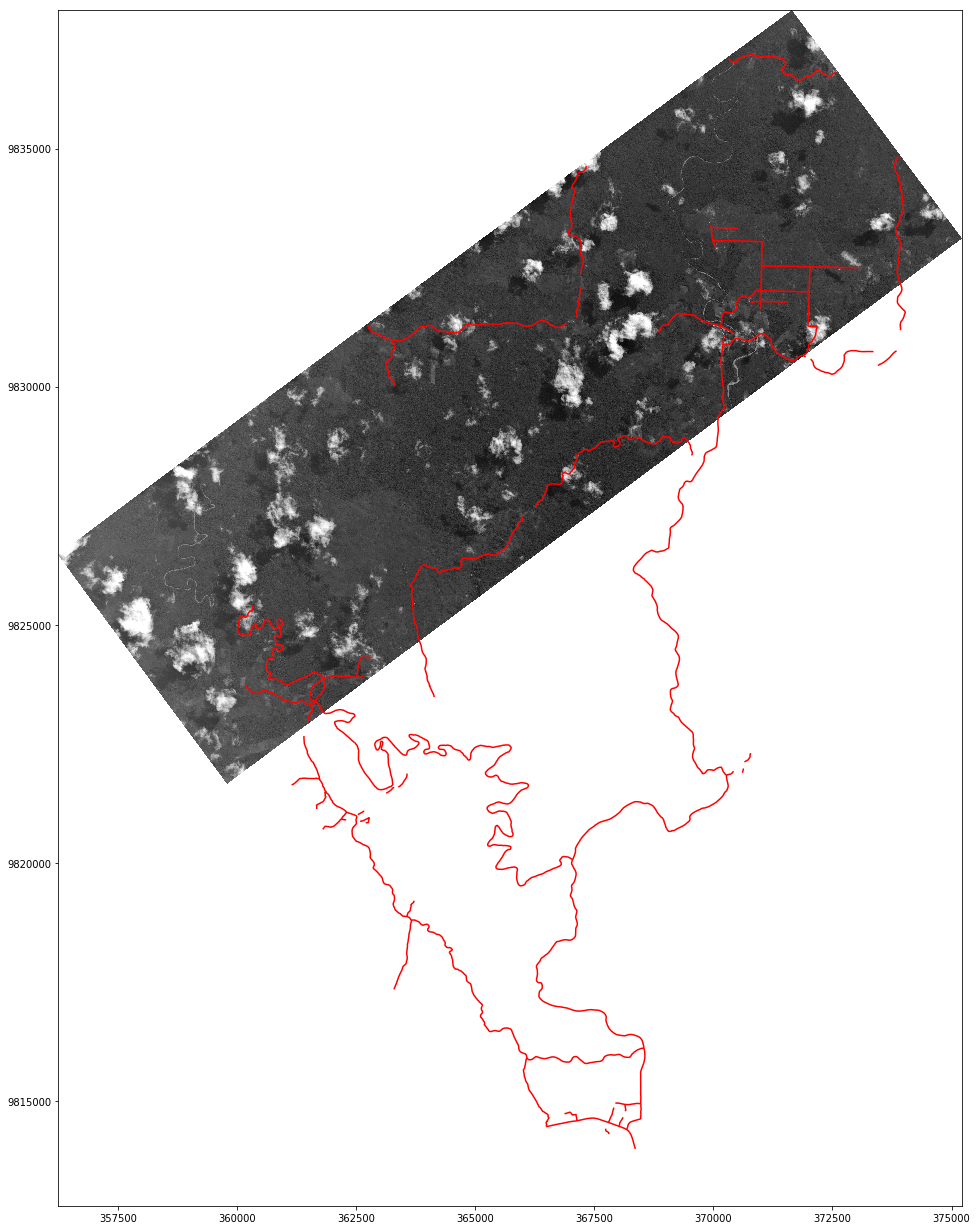

In [25]:
# plot them together
fig, ax = plt.subplots()
show(ds, ax=ax, cmap='gray')
rd_transformed.iloc[1::,:].plot(ax=ax, color='red')